# ライブラリのimport

In [2]:
from models.DCmodel import ACGenerator, CGenerator
from options import get_parser
from mylib import *
import word2vec
import torch
from PIL import Image
import random
import torchvision.models as models
from dataset import *
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import pandas as pd
import torch.optim as optim

# モデルのパスやword2vecモデルを定義

In [3]:
Cmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/CGAN/model_100'
ACmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/ACGAN/model_50'
CPmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/CPGAN/model_50'
Imp2Font_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/Imp2Font/model_35r'
parser = get_parser()
opts = parser.parse_args(args=[])
data = np.array([np.load(d) for d in opts.data])
Embedding_model = word2vec.word2vec()
weights = Embedding_model.vectors
ID = {}
c = 1
mask = []
for idx, key in tqdm.tqdm(enumerate(Embedding_model.vocab.keys()), total = len(Embedding_model.vocab.keys())):
    if key in opts.w2v_vocab.keys():
        ID[key] = c
        c += 1
        mask.append(idx)
    else:
        continue

 11%|█▏        | 338123/3000000 [00:00<00:00, 3381023.64it/s]

Embedding　OK


100%|██████████| 3000000/3000000 [00:00<00:00, 3838425.65it/s]


In [4]:
SEED = 1111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device ='cuda'

# 画像生成モデルと分類CNNの定義

In [18]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 26),
    nn.Softmax(dim = 1)
)
model = model.to('cuda')
model = nn.DataParallel(model)
transform= Transform()
dataset = Myfont_dataset2(data, opts.correct_impression_word_list, ID, char_num = 26, transform=transform)
num = len(dataset)
criterion = nn.CrossEntropyLoss()
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size = 256, shuffle = True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
save_dir = os.path.join('./models', 'charclass_classifier')
if os.path.isdir(save_dir) == False:
    os.makedirs(save_dir)
for epoch in range(100):
    running_loss = []
    running_acc = []
    val_acc = []
    model.train()
    for idx, train_data in tqdm.tqdm(enumerate(trainloader), total = len(trainloader)):
        image, charclass = train_data['img_target'].expand(-1,3,-1,-1), train_data['charclass_target']
        image, charclass = image.to(device), charclass.to(device)
        optimizer.zero_grad()
        pred = model(image)
        _, pred_=torch.max(pred, 1)
        acc = (pred_ == charclass).sum().item()/len(charclass)
        loss = criterion(pred, charclass)
        running_loss.append(loss.item())
        running_acc.append(acc)
        loss.backward()  # 誤差逆伝播
        optimizer.step() # パラメータ更新
    model.eval()
    for i, val_data in enumerate(valloader):
        xx, yy = val_data['img_target'].expand(-1,3,-1,-1), val_data['charclass_target']
        xx, yy = xx.to(device), yy.to(device)
        pred = model(xx)
        _, pred_=torch.max(pred, 1)
        acc = (pred_ == yy).sum().item()/len(yy)
        val_acc.append(acc)
    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()
    total_val_acc = np.asarray(val_acc).mean()
    print(f"Epoch: {epoch}, loss: {total_batch_loss}.")
    print(f"Epoch: {epoch}, accuracy: {total_batch_acc}.")
    print(f"Epoch: {epoch}, accuracy: {total_val_acc}.")
    if epoch%5==0:
        model_path = f'charclassifer_model_{epoch}.pth'
        torch.save(model.state_dict(), os.path.join('./models', 'charclass_classifier', model_path))

  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 0, loss: 2.865401985225606.
Epoch: 0, accuracy: 0.45574212670805325.
Epoch: 0, accuracy: 0.5560497856745525.


  0%|          | 1/1335 [00:00<03:30,  6.34it/s]

Epoch: 1, loss: 2.7222197186187858.
Epoch: 1, accuracy: 0.5993947393455099.
Epoch: 1, accuracy: 0.6053433604103269.


  0%|          | 1/1335 [00:00<03:43,  5.97it/s]

Epoch: 2, loss: 2.681340490119734.
Epoch: 2, accuracy: 0.6403763408966532.
Epoch: 2, accuracy: 0.673372645078695.


  0%|          | 1/1335 [00:00<03:30,  6.33it/s]

Epoch: 3, loss: 2.6420132310202953.
Epoch: 3, accuracy: 0.6798590802592649.
Epoch: 3, accuracy: 0.6496008367486338.


  0%|          | 1/1335 [00:00<03:30,  6.34it/s]

Epoch: 4, loss: 2.6365504775600934.
Epoch: 4, accuracy: 0.6853187181476921.
Epoch: 4, accuracy: 0.6779690490944341.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 5, loss: 2.6329738272263317.
Epoch: 5, accuracy: 0.6888752875258667.
Epoch: 5, accuracy: 0.6948010357359052.


  0%|          | 1/1335 [00:00<03:30,  6.33it/s]

Epoch: 6, loss: 2.6283386744809953.
Epoch: 6, accuracy: 0.6935837640876985.
Epoch: 6, accuracy: 0.6849745053949479.


  0%|          | 1/1335 [00:00<03:26,  6.47it/s]

Epoch: 7, loss: 2.6308875151787805.
Epoch: 7, accuracy: 0.6910029655781301.
Epoch: 7, accuracy: 0.6798870241075227.


  0%|          | 1/1335 [00:00<03:28,  6.41it/s]

Epoch: 8, loss: 2.6284088386578506.
Epoch: 8, accuracy: 0.6935652592863373.
Epoch: 8, accuracy: 0.6728372149144335.


  0%|          | 1/1335 [00:00<03:18,  6.71it/s]

Epoch: 9, loss: 2.625194184521164.
Epoch: 9, accuracy: 0.6967282575932482.
Epoch: 9, accuracy: 0.7010438651385753.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 10, loss: 2.626650543070018.
Epoch: 10, accuracy: 0.695298871915243.
Epoch: 10, accuracy: 0.694906166151304.


  0%|          | 1/1335 [00:00<03:10,  7.00it/s]

Epoch: 11, loss: 2.6241555099630176.
Epoch: 11, accuracy: 0.6978821021026799.
Epoch: 11, accuracy: 0.6877486701801315.


  0%|          | 1/1335 [00:00<03:22,  6.57it/s]

Epoch: 12, loss: 2.5977537108717788.
Epoch: 12, accuracy: 0.7242037591067672.
Epoch: 12, accuracy: 0.7281746701269591.


  0%|          | 1/1335 [00:00<03:30,  6.34it/s]

Epoch: 13, loss: 2.587845606214545.
Epoch: 13, accuracy: 0.7341356534212371.
Epoch: 13, accuracy: 0.7269724766655213.


  0%|          | 1/1335 [00:00<03:13,  6.91it/s]

Epoch: 14, loss: 2.5772455678004005.
Epoch: 14, accuracy: 0.7447927488969267.
Epoch: 14, accuracy: 0.7596656073099702.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 15, loss: 2.5568476273325946.
Epoch: 15, accuracy: 0.7651701960734014.
Epoch: 15, accuracy: 0.7663669842691666.


  0%|          | 1/1335 [00:00<03:31,  6.30it/s]

Epoch: 16, loss: 2.55569242323829.
Epoch: 16, accuracy: 0.7663259779086073.
Epoch: 16, accuracy: 0.7628069935947777.


  0%|          | 1/1335 [00:00<03:30,  6.34it/s]

Epoch: 17, loss: 2.5557373391555043.
Epoch: 17, accuracy: 0.7662859220281155.
Epoch: 17, accuracy: 0.7640677277616897.


  0%|          | 1/1335 [00:00<03:19,  6.70it/s]

Epoch: 18, loss: 2.5543254670132414.
Epoch: 18, accuracy: 0.7677113528893678.
Epoch: 18, accuracy: 0.7381392440528779.


  0%|          | 1/1335 [00:00<03:24,  6.53it/s]

Epoch: 19, loss: 2.5565976164314184.
Epoch: 19, accuracy: 0.7654490373762249.
Epoch: 19, accuracy: 0.7662548238563855.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 20, loss: 2.5525181818544196.
Epoch: 20, accuracy: 0.7695075611820841.
Epoch: 20, accuracy: 0.7724042182029385.


  0%|          | 1/1335 [00:00<03:30,  6.33it/s]

Epoch: 21, loss: 2.5511204226633137.
Epoch: 21, accuracy: 0.7708915332717665.
Epoch: 21, accuracy: 0.7708837575872846.


  0%|          | 1/1335 [00:00<03:32,  6.28it/s]

Epoch: 22, loss: 2.5515735853030885.
Epoch: 22, accuracy: 0.7704775200733672.
Epoch: 22, accuracy: 0.7719012538447696.


  0%|          | 1/1335 [00:00<03:45,  5.91it/s]

Epoch: 23, loss: 2.5509401366058806.
Epoch: 23, accuracy: 0.7710865484924667.
Epoch: 23, accuracy: 0.770572776066719.


  0%|          | 1/1335 [00:00<03:18,  6.71it/s]

Epoch: 24, loss: 2.553330804524797.
Epoch: 24, accuracy: 0.7686604554666256.
Epoch: 24, accuracy: 0.766694518238114.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 25, loss: 2.5528702526949765.
Epoch: 25, accuracy: 0.7691593235339388.
Epoch: 25, accuracy: 0.7703504364222374.


  0%|          | 1/1335 [00:00<03:32,  6.28it/s]

Epoch: 26, loss: 2.553201305017936.
Epoch: 26, accuracy: 0.7688573679304979.
Epoch: 26, accuracy: 0.7108679669349824.


  0%|          | 1/1335 [00:00<03:29,  6.38it/s]

Epoch: 27, loss: 2.5516687052080247.
Epoch: 27, accuracy: 0.7703828583277751.
Epoch: 27, accuracy: 0.7678336973593797.


  0%|          | 1/1335 [00:00<03:24,  6.51it/s]

Epoch: 28, loss: 2.5505827616216536.
Epoch: 28, accuracy: 0.7714371376532759.
Epoch: 28, accuracy: 0.7715761484203724.


  0%|          | 1/1335 [00:00<03:42,  6.00it/s]

Epoch: 29, loss: 2.5500984024019275.
Epoch: 29, accuracy: 0.7719540562524584.
Epoch: 29, accuracy: 0.7715949376861031.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 30, loss: 2.5513373105267014.
Epoch: 30, accuracy: 0.7707013012415986.
Epoch: 30, accuracy: 0.7686124932512026.


  0%|          | 1/1335 [00:00<03:30,  6.34it/s]

Epoch: 31, loss: 2.549992233626405.
Epoch: 31, accuracy: 0.7720438546423135.
Epoch: 31, accuracy: 0.7730286097886194.


  0%|          | 1/1335 [00:00<03:26,  6.46it/s]

Epoch: 32, loss: 2.5486518038346078.
Epoch: 32, accuracy: 0.773387931181913.
Epoch: 32, accuracy: 0.7680066352949838.


  0%|          | 1/1335 [00:00<03:28,  6.40it/s]

Epoch: 33, loss: 2.5506889691513575.
Epoch: 33, accuracy: 0.771375811271869.
Epoch: 33, accuracy: 0.7637589830584732.


  0%|          | 1/1335 [00:00<03:16,  6.78it/s]

Epoch: 34, loss: 2.5514464103327263.
Epoch: 34, accuracy: 0.7705989302755117.
Epoch: 34, accuracy: 0.7685049982003206.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 35, loss: 2.548433952831597.
Epoch: 35, accuracy: 0.7736322747250868.
Epoch: 35, accuracy: 0.7723879213908249.


  0%|          | 1/1335 [00:00<03:36,  6.15it/s]

Epoch: 36, loss: 2.5513915985264584.
Epoch: 36, accuracy: 0.7706569565226686.
Epoch: 36, accuracy: 0.7704275746662412.


  0%|          | 1/1335 [00:00<03:47,  5.87it/s]

Epoch: 37, loss: 2.5497421784347365.
Epoch: 37, accuracy: 0.772338929399039.
Epoch: 37, accuracy: 0.768888580421125.


  0%|          | 1/1335 [00:00<03:38,  6.12it/s]

Epoch: 38, loss: 2.551749724841743.
Epoch: 38, accuracy: 0.7702907084252562.
Epoch: 38, accuracy: 0.7699997034619286.


  0%|          | 1/1335 [00:00<03:37,  6.13it/s]

Epoch: 39, loss: 2.5496118190136743.
Epoch: 39, accuracy: 0.7724286877062917.
Epoch: 39, accuracy: 0.7720954095906547.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 40, loss: 2.5495237604062657.
Epoch: 40, accuracy: 0.772530150133395.
Epoch: 40, accuracy: 0.7730473990543504.


  0%|          | 1/1335 [00:00<03:29,  6.38it/s]

Epoch: 41, loss: 2.5462305751186185.
Epoch: 41, accuracy: 0.7758374725300566.
Epoch: 41, accuracy: 0.7717398834503124.


  0%|          | 1/1335 [00:00<03:19,  6.68it/s]

Epoch: 42, loss: 2.5498652617136637.
Epoch: 42, accuracy: 0.7722057749944418.
Epoch: 42, accuracy: 0.7681097206202349.


  0%|          | 1/1335 [00:00<03:24,  6.51it/s]

Epoch: 43, loss: 2.546824046645718.
Epoch: 43, accuracy: 0.7752395737135087.
Epoch: 43, accuracy: 0.7715013109027846.


  0%|          | 1/1335 [00:00<03:17,  6.74it/s]

Epoch: 44, loss: 2.5479293901822095.
Epoch: 44, accuracy: 0.7741521193542318.
Epoch: 44, accuracy: 0.7713540005030922.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 45, loss: 2.5339399589581437.
Epoch: 45, accuracy: 0.7881253153164709.
Epoch: 45, accuracy: 0.8046857105461208.


  0%|          | 1/1335 [00:00<03:26,  6.45it/s]

Epoch: 46, loss: 2.5168874378061474.
Epoch: 46, accuracy: 0.8051685713919243.
Epoch: 46, accuracy: 0.8053218614001505.


  0%|          | 1/1335 [00:00<03:21,  6.62it/s]

Epoch: 47, loss: 2.515220832288935.
Epoch: 47, accuracy: 0.8068408175568211.
Epoch: 47, accuracy: 0.798676532692811.


  0%|          | 1/1335 [00:00<03:28,  6.39it/s]

Epoch: 48, loss: 2.517150911052575.
Epoch: 48, accuracy: 0.8049154497588631.
Epoch: 48, accuracy: 0.8088490667231111.


  0%|          | 1/1335 [00:00<03:21,  6.61it/s]

Epoch: 49, loss: 2.513638788751895.
Epoch: 49, accuracy: 0.808431508987054.
Epoch: 49, accuracy: 0.808311016287098.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 50, loss: 2.514579498991091.
Epoch: 50, accuracy: 0.8074986398636979.
Epoch: 50, accuracy: 0.8025243698054709.


  0%|          | 1/1335 [00:00<03:13,  6.91it/s]

Epoch: 51, loss: 2.51516595976183.
Epoch: 51, accuracy: 0.8069094790544353.
Epoch: 51, accuracy: 0.8043581126681063.


  0%|          | 1/1335 [00:00<03:10,  6.99it/s]

Epoch: 52, loss: 2.513480302189173.
Epoch: 52, accuracy: 0.808577316133087.
Epoch: 52, accuracy: 0.8070645977512187.


  0%|          | 1/1335 [00:00<03:40,  6.05it/s]

Epoch: 53, loss: 2.513274135125264.
Epoch: 53, accuracy: 0.8087841958040464.
Epoch: 53, accuracy: 0.8071462096299205.


  0%|          | 1/1335 [00:00<03:17,  6.76it/s]

Epoch: 54, loss: 2.5144318682424136.
Epoch: 54, accuracy: 0.8076113120585569.
Epoch: 54, accuracy: 0.7998132832695266.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 55, loss: 2.5163463310356.
Epoch: 55, accuracy: 0.8057313578489217.
Epoch: 55, accuracy: 0.8100093997455907.


  0%|          | 1/1335 [00:00<03:34,  6.21it/s]

Epoch: 56, loss: 2.513993002502213.
Epoch: 56, accuracy: 0.8080741191447334.
Epoch: 56, accuracy: 0.8024891559094925.


  0%|          | 1/1335 [00:00<03:27,  6.43it/s]

Epoch: 57, loss: 2.5151676481582697.
Epoch: 57, accuracy: 0.8068978550997895.
Epoch: 57, accuracy: 0.8069545463376526.


  0%|          | 1/1335 [00:00<03:27,  6.43it/s]

Epoch: 58, loss: 2.5118933534800783.
Epoch: 58, accuracy: 0.8101447195714261.
Epoch: 58, accuracy: 0.8092796221082427.


  0%|          | 1/1335 [00:00<03:11,  6.98it/s]

Epoch: 59, loss: 2.5128186729516875.
Epoch: 59, accuracy: 0.809256155084398.
Epoch: 59, accuracy: 0.8033429810461045.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 60, loss: 2.5104127651743227.
Epoch: 60, accuracy: 0.8116453587553231.
Epoch: 60, accuracy: 0.8097495454787147.


  0%|          | 1/1335 [00:00<03:22,  6.58it/s]

Epoch: 61, loss: 2.5119666167412804.
Epoch: 61, accuracy: 0.810116488058591.
Epoch: 61, accuracy: 0.8096279265240012.


  0%|          | 1/1335 [00:00<03:23,  6.55it/s]

Epoch: 62, loss: 2.5122478283299934.
Epoch: 62, accuracy: 0.8098082662083355.
Epoch: 62, accuracy: 0.8080211886677464.


  0%|          | 1/1335 [00:00<03:23,  6.57it/s]

Epoch: 63, loss: 2.5118947661324835.
Epoch: 63, accuracy: 0.8101642531595781.
Epoch: 63, accuracy: 0.8086456441624946.


  0%|          | 1/1335 [00:00<03:30,  6.32it/s]

Epoch: 64, loss: 2.513748770795958.
Epoch: 64, accuracy: 0.8083150022232485.
Epoch: 64, accuracy: 0.8077521954042733.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 65, loss: 2.5118614321790833.
Epoch: 65, accuracy: 0.8102106153694868.
Epoch: 65, accuracy: 0.8089145735169007.


  0%|          | 1/1335 [00:00<03:17,  6.77it/s]

Epoch: 66, loss: 2.5101099198230643.
Epoch: 66, accuracy: 0.8119589783960119.
Epoch: 66, accuracy: 0.8045172462452146.


  0%|          | 1/1335 [00:00<03:31,  6.31it/s]

Epoch: 67, loss: 2.5115490113304797.
Epoch: 67, accuracy: 0.8105452115720075.
Epoch: 67, accuracy: 0.8097426432994667.


  0%|          | 1/1335 [00:00<03:36,  6.17it/s]

Epoch: 68, loss: 2.5120224633020407.
Epoch: 68, accuracy: 0.8100477063131702.
Epoch: 68, accuracy: 0.8068446227422206.


  0%|          | 1/1335 [00:00<03:43,  5.97it/s]

Epoch: 69, loss: 2.5146861554978046.
Epoch: 69, accuracy: 0.8073762810399673.
Epoch: 69, accuracy: 0.802903222755309.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 70, loss: 2.5151059693611515.
Epoch: 70, accuracy: 0.8069651938715304.
Epoch: 70, accuracy: 0.8088515591767285.


  0%|          | 1/1335 [00:00<03:33,  6.24it/s]

Epoch: 71, loss: 2.512709688693843.
Epoch: 71, accuracy: 0.8093561344552187.
Epoch: 71, accuracy: 0.8036331282107915.


  0%|          | 1/1335 [00:00<03:10,  6.99it/s]

Epoch: 72, loss: 2.5127195383279064.
Epoch: 72, accuracy: 0.809360129354574.
Epoch: 72, accuracy: 0.8107812295490985.


  0%|          | 1/1335 [00:00<03:12,  6.94it/s]

Epoch: 73, loss: 2.511565078421032.
Epoch: 73, accuracy: 0.810490525541703.
Epoch: 73, accuracy: 0.8082713287564216.


  0%|          | 1/1335 [00:00<03:29,  6.37it/s]

Epoch: 74, loss: 2.5132884598849863.
Epoch: 74, accuracy: 0.8087768206052366.
Epoch: 74, accuracy: 0.803836486862341.


100%|██████████| 1335/1335 [02:56<00:00,  7.57it/s]


Epoch: 75, loss: 2.5142060226268983.
Epoch: 75, accuracy: 0.8078726773468096.
Epoch: 75, accuracy: 0.8072423288668564.


  0%|          | 1/1335 [00:00<03:13,  6.88it/s]

Epoch: 76, loss: 2.5125284121724105.
Epoch: 76, accuracy: 0.809548838245857.
Epoch: 76, accuracy: 0.8091039999918196.


  0%|          | 1/1335 [00:00<03:39,  6.07it/s]

Epoch: 77, loss: 2.5124693945552528.
Epoch: 77, accuracy: 0.8096078131145998.
Epoch: 77, accuracy: 0.8012775678151892.


  0%|          | 1/1335 [00:00<03:11,  6.95it/s]

Epoch: 78, loss: 2.512328148781137.
Epoch: 78, accuracy: 0.8097312408077232.
Epoch: 78, accuracy: 0.809698226497824.


  0%|          | 1/1335 [00:00<03:13,  6.88it/s]

Epoch: 79, loss: 2.511179026771574.
Epoch: 79, accuracy: 0.8109103908000275.
Epoch: 79, accuracy: 0.8078012136587481.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 80, loss: 2.513904295610578.
Epoch: 80, accuracy: 0.8081804048449713.
Epoch: 80, accuracy: 0.804666857371323.


  0%|          | 1/1335 [00:00<03:43,  5.97it/s]

Epoch: 81, loss: 2.5103763482097383.
Epoch: 81, accuracy: 0.8116994702683289.
Epoch: 81, accuracy: 0.8101075001636072.


  0%|          | 1/1335 [00:00<03:31,  6.30it/s]

Epoch: 82, loss: 2.512120934818568.
Epoch: 82, accuracy: 0.8099526303806884.
Epoch: 82, accuracy: 0.8101661047781487.


  0%|          | 1/1335 [00:00<03:16,  6.77it/s]

Epoch: 83, loss: 2.5139541842071305.
Epoch: 83, accuracy: 0.808125304627777.
Epoch: 83, accuracy: 0.8060142522332385.


  0%|          | 1/1335 [00:00<03:32,  6.27it/s]

Epoch: 84, loss: 2.5124382485164687.
Epoch: 84, accuracy: 0.8096254093769775.
Epoch: 84, accuracy: 0.810208093035241.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 85, loss: 2.510324817293146.
Epoch: 85, accuracy: 0.8117574965154857.
Epoch: 85, accuracy: 0.8103251744461895.


  0%|          | 1/1335 [00:00<03:27,  6.42it/s]

Epoch: 86, loss: 2.5134230238668036.
Epoch: 86, accuracy: 0.8086363310844322.
Epoch: 86, accuracy: 0.8020191047208861.


  0%|          | 1/1335 [00:00<03:33,  6.25it/s]

Epoch: 87, loss: 2.5109291553497313.
Epoch: 87, accuracy: 0.8111703131145999.
Epoch: 87, accuracy: 0.8065358780390038.


  0%|          | 1/1335 [00:00<03:49,  5.81it/s]

Epoch: 88, loss: 2.5118585275800043.
Epoch: 88, accuracy: 0.810222319489337.
Epoch: 88, accuracy: 0.8081426798043257.


  0%|          | 1/1335 [00:00<03:30,  6.35it/s]

Epoch: 89, loss: 2.5108305598912612.
Epoch: 89, accuracy: 0.8112312253091171.
Epoch: 89, accuracy: 0.8015302642665488.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 90, loss: 2.512678795360894.
Epoch: 90, accuracy: 0.809408883159749.
Epoch: 90, accuracy: 0.8102151230326233.


  0%|          | 1/1335 [00:00<03:18,  6.71it/s]

Epoch: 91, loss: 2.5114179914810237.
Epoch: 91, accuracy: 0.8106719794819831.
Epoch: 91, accuracy: 0.8064586758859331.


  0%|          | 1/1335 [00:00<03:23,  6.56it/s]

Epoch: 92, loss: 2.510053338540181.
Epoch: 92, accuracy: 0.8120296573846049.
Epoch: 92, accuracy: 0.8088912467074048.


  0%|          | 1/1335 [00:00<03:30,  6.34it/s]

Epoch: 93, loss: 2.5101743646328813.
Epoch: 93, accuracy: 0.8119213942759906.
Epoch: 93, accuracy: 0.8062690576838126.


  0%|          | 1/1335 [00:00<03:25,  6.49it/s]

Epoch: 94, loss: 2.5093856143594233.
Epoch: 94, accuracy: 0.8126918887777265.
Epoch: 94, accuracy: 0.8130477646142141.


  0%|          | 0/1335 [00:00<?, ?it/s]

Epoch: 95, loss: 2.5087983458229663.
Epoch: 95, accuracy: 0.8132760659834453.
Epoch: 95, accuracy: 0.8063438952014004.


  0%|          | 1/1335 [00:00<03:30,  6.35it/s]

Epoch: 96, loss: 2.5120429185445836.
Epoch: 96, accuracy: 0.8100360021933201.
Epoch: 96, accuracy: 0.8106153216108767.


  0%|          | 1/1335 [00:00<03:31,  6.30it/s]

Epoch: 97, loss: 2.5113219918383196.
Epoch: 97, accuracy: 0.8107572485377867.
Epoch: 97, accuracy: 0.8100302980105363.


  0%|          | 1/1335 [00:00<03:40,  6.04it/s]

Epoch: 98, loss: 2.511268979690495.
Epoch: 98, accuracy: 0.8108235585227369.
Epoch: 98, accuracy: 0.8014646296546252.


100%|██████████| 1335/1335 [02:58<00:00,  7.48it/s]


Epoch: 99, loss: 2.5124046723940845.
Epoch: 99, accuracy: 0.8096590787628478.
Epoch: 99, accuracy: 0.80273725090802.


In [5]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 26),
    nn.Softmax(dim = 1)
)
model = model.to('cuda')
model = nn.DataParallel(model)
trained_model_path = 'models/charclass_classifier/charclassifer_model_95.pth'
trained_model = model.load_state_dict(torch.load(trained_model_path))

In [20]:
from models.DCmodel import ACGenerator, CGenerator
Imp2Font_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/Imp2Font/model_35r'
G_model = ACGenerator(weights, mask, z_dim=300, char_num=26, mode = 'CP', emb = 'w2v').to('cuda')
G_model = nn.DataParallel(G_model)
G_model.load_state_dict(torch.load(Imp2Font_path)["G_model_state_dict"], strict=False)
G_model.eval()

deepsets:False::::sum_weight:True


DataParallel(
  (module): ACGenerator(
    (w2v_layer): ImpEmbedding(
      (embed): Embedding(1574, 300)
      (fc): Sequential(
        (0): Linear(in_features=1574, out_features=1, bias=True)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (res_block): Sequential()
    )
    (layer1): Sequential(
      (0): Linear(in_features=326, out_features=1500, bias=True)
      (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer2): Sequential(
      (0): Linear(in_features=300, out_features=1500, bias=True)
      (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer3): Sequential(
      (0): Linear(in_features=3000, out_features=32768, bias=True)
      (1): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5,

In [8]:
generate_num = 30
char_num = 26
char_class = torch.eye(26).repeat(generate_num, 1)
noise = torch.normal(mean = 0.5, std = 0.2, size = (generate_num, 300))
noise = tile(noise, 0, char_num).to(device)
word_list = list(split_list(list(ID.keys()), 1))
result = {}
import gc 
for word in tqdm.tqdm(word_list, total = len(word_list)):
    gc.collect()
    label = [[ID[token] for token in word]]
    label = Multilabel_OneHot(label, len(ID), normalize = True)
    label = torch.tensor(label).repeat(char_num * generate_num, 1).to(device)
    with torch.no_grad():
        samples = G_model(noise, label, char_class)
        samples = samples.data.cpu()
        samples = (samples/2)+0.5  
#     row = generate_num
#     col = char_num
#     plt.figure(figsize=(char_num * 1 , generate_num*1))
#     num = 0
# #     print(word)
# #     while num < row * col:
# #         num += 1
# #         plt.subplot(row, col, num)
# #         plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
# #         plt.axis('off')
# #     plt.show()
    test_X = samples
    test_y = torch.argmax(char_class, dim=1)
    xx, yy = test_X.expand(-1,3,-1,-1), test_y
    xx, yy = xx.to(device), yy.to(device)
    pred = model(xx)
    _, pred_=torch.max(pred, 1)
    acc = (pred_ == yy).sum().item()/len(yy)
    token =" ".join(word)
    result[token] = acc
#    print(f'{token}:{acc}')
print(result)

  0%|          | 0/1574 [00:00<?, ?it/s]<ipython-input-8-dc5b68ec4fb6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).repeat(char_num * generate_num, 1).to(device)
  1%|          | 8/1574 [00:06<20:15,  1.29it/s]


KeyboardInterrupt: 

In [6]:
import pandas as pd
df = pd.io.json.json_normalize(result)

NameError: name 'result' is not defined

In [24]:
save_dir = os.path.join('./models', 'charclass_classifier')
df =df.T
df.to_csv(os.path.join(save_dir, 'result.csv'))

NameError: name 'df' is not defined

In [6]:
save_dir = os.path.join('./models', 'charclass_classifier')
df  = pd.read_csv(os.path.join(save_dir, 'result.csv')).rename(columns = {'Unnamed: 0':'word','0':'Accuracy'}).set_index('word')

In [7]:
df

,Accuracy
word,
on,0.774359
the,0.344872
year,0.342308
up,0.307692
out,0.820513
...,...
magazin,0.820513
avenir,0.508974
ocr,0.300000


In [8]:
df['Accuracy'].mean()

0.5346145700974162

In [9]:
df.sort_values('Accuracy',ascending=False)

,Accuracy
word,
large,0.832051
erode,0.830769
seal,0.830769
app,0.830769
feature,0.830769
...,...
ages,0.041026
secession,0.037179
futurism,0.037179


In [10]:
transform= Transform()
dataset = Myfont_dataset2(data, opts.correct_impression_word_list, ID, char_num = 26, transform=transform)
df['value_counts'] = dataset.weight

100%|██████████| 17202/17202 [00:03<00:00, 4676.33it/s]


In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(0.0, 200.0)

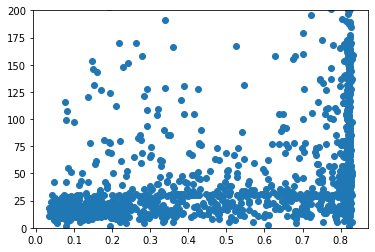

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(df['Accuracy'],df['value_counts'])
plt.ylim(0, 200)

In [13]:
df_corr = df.corr()

In [14]:
df_corr

,Accuracy,value_counts
Accuracy,1.000000,0.228331
value_counts,0.228331,1.000000


In [15]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/matsuda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
nltk_token = nltk.pos_tag(list(ID.keys()))
df_nltk = pd.io.json.json_normalize(dict(nltk_token)).T
df_nltk = df_nltk.rename(columns = {0:'part of speech'})

<ipython-input-16-4c32299e51c0>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_nltk = pd.io.json.json_normalize(dict(nltk_token)).T


In [17]:
df = df.join(df_nltk)

In [43]:
namelist = ['調節接続詩','基数', '限定詞','存在を表すthere','外国語','前置詞または従属接続詞', '形容詞', '形容詞(比較級)', '形容詞(最上級)',
       '法', '名詞', '名詞(複数形)', '固有名詞', '固有名詞(複数形)', '前限定辞', '所有格の終わり', '人称代名詞', '所有代名詞'
       ,'副詞', '副詞(比較級)', '副詞(最上級)', '不変化詞', '記号','前置詞 to', '感嘆詞', '動詞(原形)', '動詞(過去形)',
        '動詞(動名詞または現在分詞)', '動詞(過去分詞)','動詞(三人称単数以外の現在形)','動詞(三人称単数の現在)',
        'Wh 限定詞', 'Wh 代名詞', '所有 Wh 代名詞', 'Wh 副詞']
taglist = ['CC','CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS'
       'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB','VBD', 'VBG', 'VBN', 'VBP',
       'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

In [44]:
df_name = pd.io.json.json_normalize(dict(zip(taglist, namelist))).T

<ipython-input-44-acf0ebdde783>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_name = pd.io.json.json_normalize(dict(zip(taglist, namelist))).T


In [45]:
df_part = df.groupby('part of speech').mean().join(df_name).reset_index().drop(columns = ['part of speech']).set_index(0)

In [46]:
df_part.to_csv(os.path.join(save_dir, 'result_part_of_speech.csv'))

In [47]:
df.sort_values('Accuracy', ascending = False)

,Accuracy,value_counts,part of speech
word,,,
large,0.832051,159,JJ
erode,0.830769,155,NN
seal,0.830769,5,JJ
app,0.830769,97,JJ
feature,0.830769,30,NN
...,...,...,...
ages,0.041026,24,NNS
secession,0.037179,11,NN
futurism,0.037179,15,NN


In [1]:
transform= Transform()
dataset = Myfont_dataset(data, opts.correct_impression_word_list, ID, char_num = 26, transform=transform)
num = len(dataset)
print(num)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=26, shuffle=False, collate_fn = collate_fn)
result = {}
import gc 
tokens = []
acc_s = []
for data_ in tqdm.tqdm(dataloader, total = len(dataset)):
    test_X = data_['img']
    test_y = data_['charclass']
    label = data_['label']
    print(test_y)
#     test_y = torch.argmax(test_y, dim=1)
    xx, yy = test_X.expand(-1,3,-1,-1), test_y
    xx, yy = xx.to(device), yy.to(device)
    pred = model(xx)
    _, pred_=torch.max(pred, 1)
    acc = (pred_ == yy)
    tokens.extend(label)
    acc_s.append(acc.item())
#    print(f'{token}:{acc}')
print(result)

NameError: name 'Transform' is not defined

100%|██████████| 17202/17202 [00:00<00:00, 41439.32it/s]


24.0
18


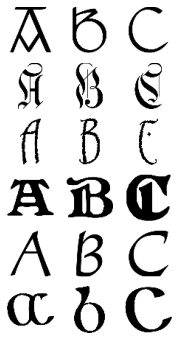

In [16]:
transform= Transform()
dataset = Myfont_dataset2(data, opts.correct_impression_word_list, ID, char_num = 3, transform=transform)
num = len(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=num, shuffle=False, collate_fn = collate_fn)
tmp = dataloader.__iter__()
ground_truth = tmp.next()
ground_imgs = ground_truth['img_target']
ground_label = ground_truth['multi_label_target']
idx =  torch.tensor([idx for idx, label in enumerate(ground_label) if 'ages' in label])
print(len(idx)/3)
idx = idx[:18]
ground_img = ground_imgs[idx]
print(len(ground_img))
row = len(ground_img)//3
col = 3
plt.figure(figsize=(col, row))
num = 0
while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(np.squeeze(ground_img[num-1]), cmap = "gray")
    plt.axis('off')